# Spike Sorting

When you record extracellular electrophysiology data, one of the first data processing steps is figuring out which action potentials (or "spikes") came from which neurons. The process of doing this is called **spike sorting**.

Below, we'll work with [this dataset](https://dandiarchive.org/dandiset/000053/0.210819.0345) from [Lisa Giocomo's lab at Stanford](https://giocomolab.weebly.com/) to demonstrate the simplest form of spike sorting: thresholding, followed by feature extraction.

<mark>**Note #1**:  The code below requires a different dataset than the one we interacted with in the last chapter. Because this dataset contains all of the raw recording data, it is much, much bigger. As a result, the best way to work with it is through the Dandihub. If you're not already running this book on the Dandihub, read [Using this Book](https://nwb4edu.github.io/Chapter_01/Using_This_Book.html) for instructions on how to run this on the Dandihub.</mark>

<mark>**Note #2**: Some of the cells below contain <code>try</code> and <code>except</code> to catch instances where these notebooks are not run in a properly configured coding environment. You can ignore these and focus on the code *after* <code>try</code>.</mark>

## Step 1. Inspect the Data

First, we need to find the correct URL for the dataset on the NWB's Amazon S3 storage system. There is a tool to do so within the dandiapi, which we'll use below to get the URL for one session within the dataset.

In [1]:
from dandi.dandiapi import DandiAPIClient

dandiset_id = '000053' # giocomo data
filepath = 'sub-npI5/sub-npI5_ses-20190414_behavior+ecephys.nwb' 

with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(filepath)
    s3_path = asset.get_content_url(follow_redirects=1, strip_query=True)
    
print(s3_path)

A newer version (0.58.0) of dandi/dandi-cli is available. You are using 0.55.1


https://dandiarchive.s3.amazonaws.com/blobs/d6d/882/d6d88284-983a-42a7-91e8-48e9f59c2881


Now that we have this path, we can stream the data rather than downloading it. Below, we'll print some useful information about this experiment. We will also access a dataset we haven't interacted with yet: [`ElectricalSeries`](https://pynwb.readthedocs.io/en/stable/tutorials/domain/ecephys.html). As the name suggests, this group contains raw electrophysiology data -- exactly what we need to sort! We will assign a portion of this to an object called `ephys_data`.

<mark>**Note**: The cell below will take about a minute to run, depending on the speed of your internet connection.</mark>

In [2]:
try:
    from pynwb import NWBHDF5IO

    with NWBHDF5IO(s3_path, mode='r', load_namespaces=True, driver='ros3') as io:
        nwbfile = io.read()
        print(nwbfile.acquisition['ElectricalSeries'].data.shape)
        sampling_freq = nwbfile.acquisition['ElectricalSeries'].rate # get the sampling frequency in Hz
        ephys_data = (nwbfile.acquisition['ElectricalSeries'].data[:3000000, 99])*nwbfile.acquisition['ElectricalSeries'].conversion
        
except ValueError:
    print('Environment is not configured for pynwb.')
    ephys_data = []
    sampling_freq = 400

Environment is not configured for pynwb.


Before we dive into spike sorting, let's take a look at the data. Below, we'll import a couple additional packages, generate a list of timestamps, and plot it.

>**Note**: Need a reminder on how some of the packages or functions below work? Look through the [NumPy](https://nwb4edu.github.io/Chapter_02/NumPy.html) and [Matplotlib](https://nwb4edu.github.io/Chapter_02/Matplotlib.html) review pages.

/Users/ashley/anaconda3/envs/jb/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ashley/anaconda3/envs/jb/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ashley/anaconda3/envs/jb/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ashley/anaconda3/envs/jb/lib/python3.11/site-packages/IPython/core/

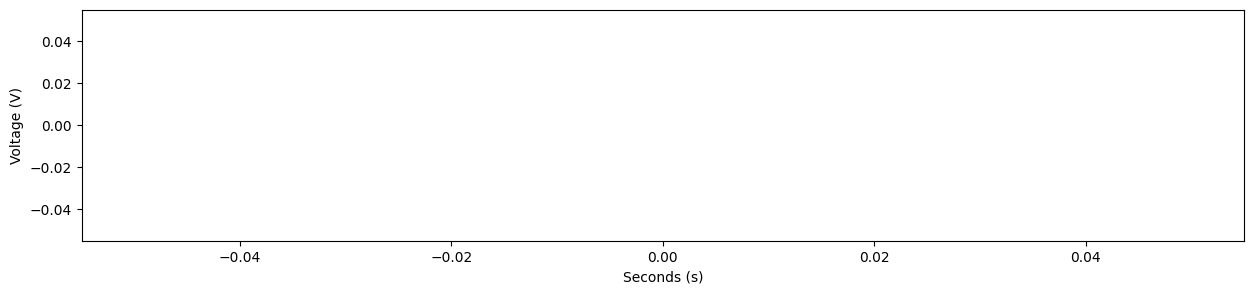

In [3]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt

# generate a vector of timestamps
timestamps = np.arange(0, len(ephys_data)) * (1.0 / sampling_freq)

fig,ax = plt.subplots(1,1,figsize=(15,3))
plt.plot(timestamps,ephys_data)
plt.ylabel('Voltage (V)')
plt.xlabel('Seconds (s)')
#plt.xlim(1.053,1.055)
plt.show()

In the data above, there are clear places where the data "spikes". These are extracellularly recorded action potentials!

## Step 2. Spike Detection

One of the most straightforward ways to spike sort is to simply detect these using a threshold. Whenever the signal passes this threshold, we'll clip that out. We could determine a reasonable threshold by eye, but we'll do this mathematically instead, using the standard deviation of the signal. When the signal is five times the standard deviation, that's enough signal to noise that it's likely to be an action potential. We'll calculate that below.

In [4]:
noise_std = np.std(ephys_data)
recommended_threshold = -5 * noise_std
print('Noise Estimate by Standard Deviation: ', noise_std)
print('Recommended Spike Threshold         : ', recommended_threshold)

Noise Estimate by Standard Deviation:  nan
Recommended Spike Threshold         :  nan


/Users/ashley/anaconda3/envs/jb/lib/python3.11/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/ashley/anaconda3/envs/jb/lib/python3.11/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/ashley/anaconda3/envs/jb/lib/python3.11/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Our spike detector needs to take into account that a spike typically comprises multiple samples, so we can't simply take each sample that exceeds the threshold as an individual spike detection. Instead, we'll define a *dead time*: whenever we detect a spike, the next few samples within the dead time won't trigger a spike detection by themselves.

In order to generate a more precise idea of where each spike is we will also search for the minimum in each spike by lookiing through the signal for a short period of time after the threshold crossing. The time of this minimum will be the timestamp for each spike.

Below, we'll define three helper functions to accomplish this detection strategy:

In [5]:
def detect_threshold_crossings(signal, fs, threshold, dead_time):
    """
    Detect threshold crossings in a signal with dead time and return them as an array
    
    The signal transitions from a sample above the threshold to a sample below the threshold for a detection and
    the last detection has to be more than dead_time apart from the current one.
    
    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param threshold: The threshold for the signal
    :param dead_time: The dead time in seconds. 
    """
    dead_time_idx = dead_time * fs
    threshold_crossings = np.diff((signal <= threshold).astype(int) > 0).nonzero()[0]
    distance_sufficient = np.insert(np.diff(threshold_crossings) >= dead_time_idx, 0, True)
    while not np.all(distance_sufficient):
        # repeatedly remove all threshold crossings that violate the dead_time
        threshold_crossings = threshold_crossings[distance_sufficient]
        distance_sufficient = np.insert(np.diff(threshold_crossings) >= dead_time_idx, 0, True)
    return threshold_crossings

def get_next_minimum(signal, index, max_samples_to_search):
    """
    Returns the index of the next minimum in the signal after an index
    
    :param signal: The signal as a 1-dimensional numpy array
    :param index: The scalar index 
    :param max_samples_to_search: The number of samples to search for a minimum after the index
    """
    search_end_idx = min(index + max_samples_to_search, signal.shape[0])
    min_idx = np.argmin(signal[index:search_end_idx])
    return index + min_idx

def align_to_minimum(signal, fs, threshold_crossings, search_range):
    """
    Returns the index of the next negative spike peak for all threshold crossings
    
    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param threshold_crossings: The array of indices where the signal crossed the detection threshold
    :param search_range: The maximum duration in seconds to search for the minimum after each crossing
    """
    search_end = int(search_range*fs)
    aligned_spikes = [get_next_minimum(signal, t, search_end) for t in threshold_crossings]
    return np.array(aligned_spikes)

Now, we can use those functions to detect threshold crossings. We'll then plot our original signal with the detected spikes marked.

/Users/ashley/anaconda3/envs/jb/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ashley/anaconda3/envs/jb/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ashley/anaconda3/envs/jb/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ashley/anaconda3/envs/jb/lib/python3.11/site-packages/IPython/core/

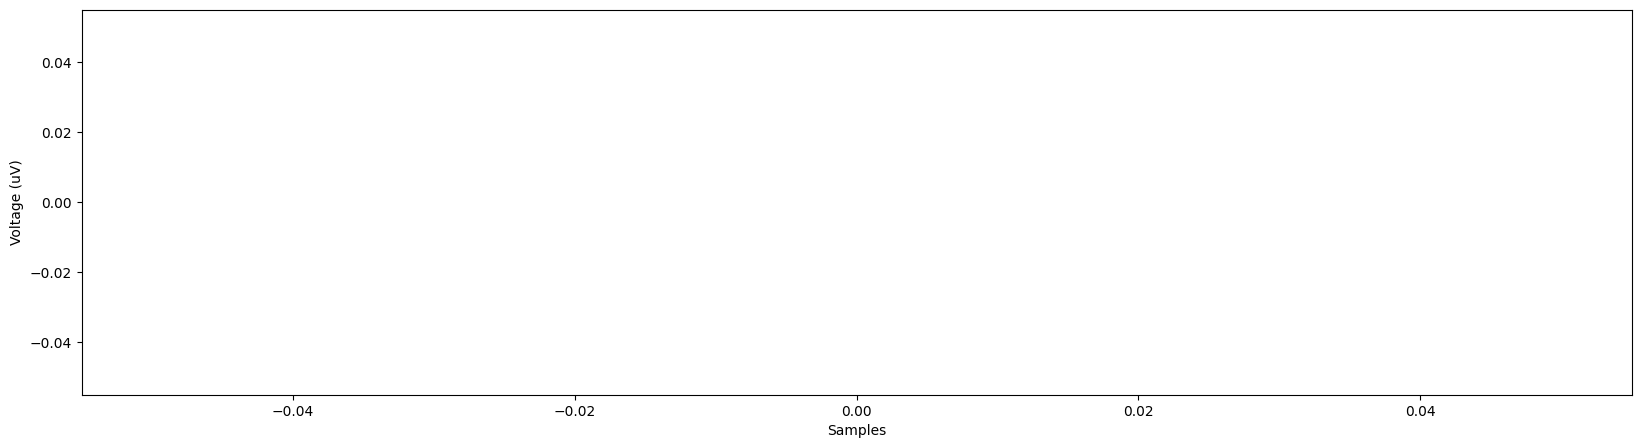

In [6]:
crossings = detect_threshold_crossings(ephys_data, sampling_freq, recommended_threshold, 0.003) # dead time of 3 ms
spks = align_to_minimum(ephys_data, sampling_freq, crossings, 0.002) # search range 2 ms

fig,ax = plt.subplots(1,1,figsize=(20,5))
plt.plot(ephys_data)
plt.xlabel('Samples')
plt.ylabel('Voltage (uV)')
plt.plot(spks,[recommended_threshold]*spks.shape[0], 'ro', ms=2)
ax.ticklabel_format(useOffset=False, style='plain')
#plt.xlim([0,len(ephys_data)])
plt.show()

Finally, we can cut out the waveforms from these detected spikes so that we can look at their shape. To do so, we will cut out a portion of the signal around each spike. Spikes too close to the start or end of the signal that a full cutout is not possible are ignored. 

The location and shape of a waveform is one of the main pieces of evidence to show that the waveform was recorded from a cell. This will help us determine whether or not there is just one or more neurons recorded on this channel. 

Below, we will define two helper functions: one to extract the waveforms, and one to plot them.

In [7]:
def extract_waveforms(signal, fs, spikes_idx, pre, post):
    """
    Extract spike waveforms as signal cutouts around each spike index as a spikes x samples numpy array
    
    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param spikes_idx: The sample index of all spikes as a 1-dim numpy array
    :param pre: The duration of the cutout before the spike in seconds
    :param post: The duration of the cutout after the spike in seconds
    """
    cutouts = []
    pre_idx = int(pre * fs)
    post_idx = int(post * fs)
    for index in spikes_idx:
        if index-pre_idx >= 0 and index+post_idx <= signal.shape[0]:
            cutout = signal[(index-pre_idx):(index+post_idx)]
            cutouts.append(cutout)
    return np.stack(cutouts)

def plot_waveforms(cutouts, fs, pre, post, n=100):
    """
    Plot an overlay of spike cutouts
    
    :param cutouts: A spikes x samples array of cutouts
    :param fs: The sampling frequency in Hz
    :param pre: The duration of the cutout before the spike in seconds
    :param post: The duration of the cutout after the spike in seconds
    :param n: The number of cutouts to plot, or None to plot all. Default: 100
    """
    if n is None:
        n = cutouts.shape[0]
    n = min(n, cutouts.shape[0])
    time_in_us = np.arange(-pre, post, 1/fs)
    plt.figure(figsize=(12,6))
    
    for i in range(n):
        plt.plot(time_in_us, cutouts[i,], color='k', linewidth=1, alpha=0.3)
        plt.xlabel('Time (s)')
        plt.ylabel('Voltage (V)' )

    plt.show()

Now, let's extract & plot the waveforms.

In [8]:
try:
    pre = 0.001 # 1 ms
    post= 0.002 # 2 ms
    waveforms = extract_waveforms(ephys_data, sampling_freq, spks, pre, post)
    plot_waveforms(waveforms, sampling_freq, pre, post, n=500)
    min_voltage = np.amin(waveforms, axis=1)
    max_voltage = np.amax(waveforms, axis=1)

except ValueError:
    print('No data loaded.')
    min_voltage, max_voltage = 0,0

No data loaded.


Looking at the plot above, would you say there is just one waveform here, or multiple?

## Step 3. Feature Extraction

Indeed, it looks like there might be two -- one that is very high amplitude, and another that is lower amplitude. We can use **feature extraction** to investigate our waveforms. Below, we'll plot the minimum and maximum voltages in the recorded waveforms to see if there are distinct clusters of waveforms.

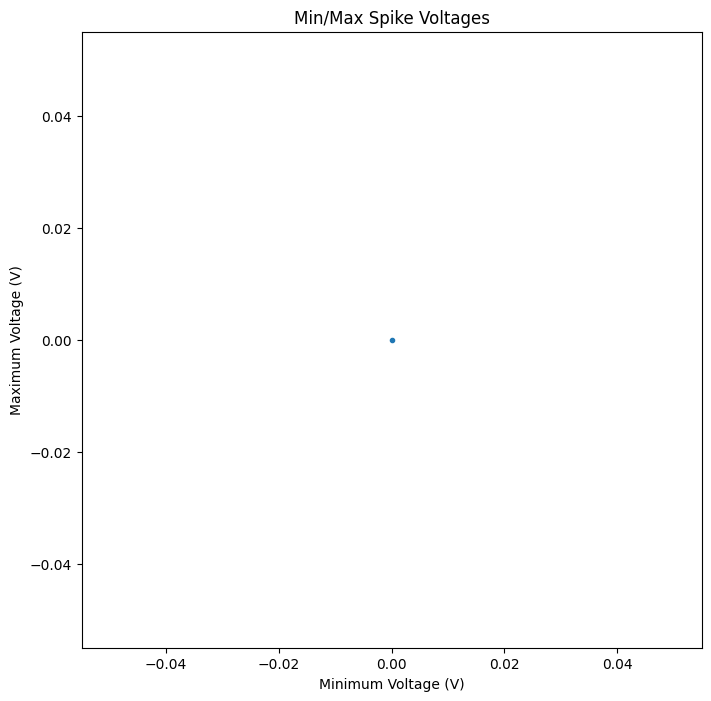

In [9]:
plt.figure(figsize=(8,8))
plt.plot(min_voltage, max_voltage,'.')
plt.xlabel('Minimum Voltage (V)')
plt.ylabel('Maximum Voltage (V)')
plt.title('Min/Max Spike Voltages')

plt.show()

Looking at the scatterplot above, would you say there is more than one cluster of waveforms?

For these two units, separating by minimum & maximum voltage actually works fairly well! However, many action potentials have shapes that cannot be easily summarized by one feature such as the minimum voltage. For this, a more general feature extraction method such as principal component analysis (PCA) is typically used.

## Notebook summary
In this notebook, we've looked closely at just 100 seconds of one channel in a 384-channel recording. You can imagine how long spike sorting would take if we needed to do this for *all* of the data. Thankfully, there are more automated spikesorting tools which enable researchers to automatically sort their data, with just a little bit of sorting by hand. In the next notebook, we'll work with data that has already been sorted for us. The resulting data simply has spike times for each sorted neuron (or "unit") -- the moments in the experiment where a spike happened. This is the most common format for data sharing of extracellularly recorded data, since it's much more concise, and the hard work of spike sorting has already happened.

## Notes & resources
This notebook borrows inspiration and code from [this tutorial](https://github.com/multichannelsystems/McsPyDataTools/blob/master/McsPyDataTools/docs/McsPy-Tutorial_DataAnalysis.ipynb) which is protected under a copyright: Copyright (c) 2018, Multi Channel Systems MCS GmbH
All rights reserved.